# Prospective Evaluation of Targeted Literature Search: Oesophageal Carcinoma

In [1]:
from dotenv import load_dotenv
load_dotenv()

False

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
OVERWRITE_LATEX_OUTPUT = True

In [4]:
GUIDELINE_ID = "oesophaguskarzinom"
SCREENING_TF_MIN = "09/01/2019" # 09/01/2019 stated in report, but some PMIDs are included anyway
SCREENING_TF_MAX = "03/04/2022"

In [5]:
PATH_PREFIX = "esophagus"
PATH_GGPONC_LITERATURE = Path("data/screening/ggponc_v2.1_2023_03_30_literature.csv")
PATH_RIS_CONTENT = Path(f"data/screening/{PATH_PREFIX}/ris_with_matched_ids.csv")
PATH_MANUAL_REVIEW = Path(f"data/screening/{PATH_PREFIX}/manual_review.csv")
PATH_QUERY_RESULT = Path(f"data/screening/{PATH_PREFIX}/retrieved_evidence.parquet")
PATH_UNSCREENED_HQ = Path(f"data/screening/{PATH_PREFIX}/unscreened_hq.csv")

PATH_LATEX_TABLE_OUTPUT = Path(
    f"output/latex/from_python/tables/evaluation/{PATH_PREFIX}/"
)
PATH_LATEX_PLOT_OUTPUT = Path(
    f"output/latex/from_python/figures/evaluation/{PATH_PREFIX}/"
)
PATH_LATEX_TABLE_OUTPUT.mkdir(exist_ok=True, parents=True)
PATH_LATEX_PLOT_OUTPUT.mkdir(exist_ok=True, parents=True)

In [6]:
from api.app import app
from fastapi.testclient import TestClient
import os

with TestClient(app) as client:
    # Initialize state
    pass    

session = app.state.session()

## Screened evidence

In [7]:
import pandas as pd

In [8]:
df_s = pd.read_csv(
    PATH_RIS_CONTENT,
    parse_dates=["publication_date", "article_date_api"],
).astype({"pm_id": "Int64"})

In [9]:
import ast

df_s["publication_types"] = df_s["publication_types"].apply(ast.literal_eval)

In [10]:
pd.crosstab(df_s["is_included"], df_s["is_rct_api"], margins=True)

is_rct_api,False,True,All
is_included,,,
False,2643,302,2945
True,52,29,81
All,2695,331,3026


In [11]:
pd.crosstab(df_s["is_relevant"], df_s["is_rct_api"], margins=True)

is_rct_api,False,True,All
is_relevant,,,
False,2640,296,2936
True,55,35,90
All,2695,331,3026


In [12]:
df_s.groupby(['screening_origin', 'is_relevant', 'is_rct_api']).size()

screening_origin  is_relevant  is_rct_api
manual            False        False            3
                               True             6
                  True         True             9
original          False        False         2637
                               True           290
                  True         False           55
                               True            26
dtype: int64

## Retrieved Evidence

In [13]:
from integration.citation_utils import pm_id_to_publication_date
from evaluation.matching import is_in_ggponc
from tqdm.auto import tqdm
import os
from requests.exceptions import ConnectionError

if PATH_QUERY_RESULT.exists():
    df_query = pd.read_parquet(PATH_QUERY_RESULT).astype({"pm_id": "Int64"})
else:
    query = EvidenceQuery(guideline_id=GUIDELINE_ID)
    try:
        # fetch evidence from API
        print("Fetching evidence from API")
        evidence = query_api_for_evidence(query=query)
        df_query = evidence_to_df(evidence)
        df_query["guideline_id"] = GUIDELINE_ID
        print("Done.")

        # retrieve exact article dates from Pubmed API
        tqdm.pandas(desc="Fetching article dates")
        df_query["article_date_api"] = pd.to_datetime(
            df_query["pm_id"].progress_apply(
                lambda pm_id: pm_id_to_publication_date(
                    pm_id=pm_id,
                    email=os.environ.get("PUBMED_USER"),
                    api_key=os.environ.get("PUBMED_API_KEY"),
                    cache_path="data/literature/pm_id_to_entrez_xml.json",
                )
            )
        )

        # exclude articles outside of screening timeframe
        df_query["publication_date_combined"] = df_query["article_date_api"].fillna(
            df_query["publication_date"]
        )
        df_query = df_query.query(
            "(publication_date_combined >= @SCREENING_TF_MIN & publication_date_combined <= @SCREENING_TF_MAX)"
        )

        # check presence in GGPONC
        df_ggponc = (
            pd.read_csv(PATH_GGPONC_LITERATURE)
            .astype({"pm_id": "Int64"})
            .query("guideline_id == @GUIDELINE_ID")
        )
        ggponc_pm_ids = set(df_ggponc["pm_id"].dropna())
        ggponc_titles = set(df_ggponc["title"])

        tqdm.pandas(desc="Checking for presence in GGPONC")
        df_query = df_query.progress_apply(  # type: ignore
            lambda row: is_in_ggponc(
                row=row, ggponc_pm_ids=ggponc_pm_ids, ggponc_titles=ggponc_titles
            ),
            axis=1,
        )

        df_query.to_parquet(PATH_QUERY_RESULT)
    except ConnectionError:
        print("Can't connect to the API, is it running?")

In [14]:
pd.crosstab(df_query["source"], df_query["is_in_ggponc"], margins=True)

is_in_ggponc,False,True,All
source,,,
Civic,4,0,4
ClinicalTrials,40,0,40
Pubmed,316,10,326
All,360,10,370


In [15]:
pd.crosstab(df_s["is_included"], df_s["is_in_ggponc"], margins=True)

is_in_ggponc,False,True,All
is_included,,,
False,2934,11,2945
True,76,5,81
All,3010,16,3026


In [16]:
pd.crosstab(df_s["is_relevant"], df_s["is_in_ggponc"], margins=True)

is_in_ggponc,False,True,All
is_relevant,,,
False,2934,2,2936
True,76,14,90
All,3010,16,3026


In [17]:
df_s.groupby(['screening_origin', 'is_relevant', 'is_rct_api']).size()

screening_origin  is_relevant  is_rct_api
manual            False        False            3
                               True             6
                  True         True             9
original          False        False         2637
                               True           290
                  True         False           55
                               True            26
dtype: int64

## Retrieval Evaluation using the Pubmed data

For the evaluation, we only look at results retrieved from Pubmed:

In [18]:
df_r = df_query.query("source == 'Pubmed'").copy()

Check if CIViC results are already in PubMed result

In [19]:
df_civic = df_query.query("source == 'Civic'")
for pm_id in df_civic.pm_id:
    print(pm_id, pm_id in df_r.pm_id.values)

34912120 True
32469182 True
32308431 False
31908417 False


Furthermore, we consider all results that we can retrieve from GGPONC as having been screened and included, thus making them relevant. We therefor add these records to the dataframe containing the screened records:

In [20]:
from evaluation.matching import add_unscreened_ggponc_citations

In [21]:
df_s_with_ggponc = add_unscreened_ggponc_citations(df_s, df_r)

In [22]:
from evaluation.metrics import FILTERS_SCREENED, FILTERS_RETRIEVED

In [23]:
from evaluation.metrics import run_evaluation

metrics = run_evaluation(
    df_s_with_ggponc.query("screening_origin == 'original'"),
    df_r,
    filters_screened=FILTERS_SCREENED,
    filters_retrieved=FILTERS_RETRIEVED,
    col_id="pm_id",
    col_relevant="is_relevant",
    compute_combinations=False,
)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/14 [00:00<?, ?it/s]

In [24]:
from evaluation.plotting import draw_venn_rsi

### All evidence with a Pubmed ID

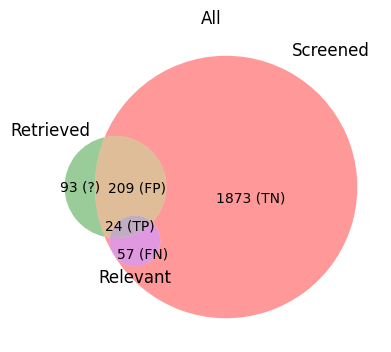

In [25]:
draw_venn_rsi(
    title="All",
    ids_retrieved=metrics["All"]["All"]["ids_retrieved"],
    ids_screened=metrics["All"]["All"]["ids_screened"],
    ids_screened_relevant=metrics["All"]["All"]["ids_screened_relevant"],
    add_pn_labels=True,
);

In [26]:
from evaluation.metrics import metrics_to_df, highlight_metrics

In [27]:
highlight_metrics(
    metrics_to_df(metrics["All"], drop_zero_tp=False).head(len(FILTERS_RETRIEVED))
)

,Precision,Recall,$F_1$,TP,FP,FN,TN,?,Retrieved,Screened,Relevant
All,0.1030,0.2963,0.152900,24,209,57,1873,93,326,2163,81
Is RCT,0.1358,0.2716,0.181100,22,140,59,1942,48,210,2163,81
Non-empty Abstract,0.1030,0.2963,0.152900,24,209,57,1873,89,322,2163,81
Non-pediatric population,0.1034,0.2963,0.153400,24,208,57,1874,93,325,2163,81
Phase >= 2,0.1587,0.2469,0.193200,20,106,61,1976,36,162,2163,81
Phase >= 3,0.3091,0.2099,0.250000,17,38,64,2044,8,63,2163,81
Sample Size >= 5,0.1031,0.2840,0.151300,23,200,58,1882,87,310,2163,81
Sample Size >= 10,0.1045,0.2840,0.152800,23,197,58,1885,86,306,2163,81
Sample Size >= 15,0.1065,0.2840,0.154900,23,193,58,1889,80,296,2163,81
Known Intervention,0.1212,0.2963,0.172000,24,174,57,1908,65,263,2163,81


### RCTs only

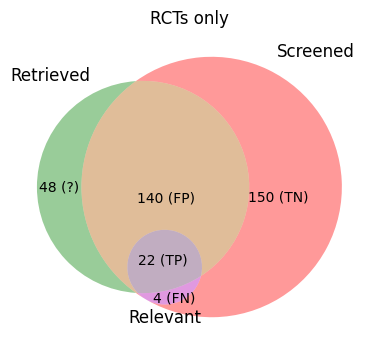

In [28]:
draw_venn_rsi(
    title="RCTs only",
    ids_retrieved=metrics["Only RCTs"]["Is RCT"]["ids_retrieved"],
    ids_screened=metrics["Only RCTs"]["Is RCT"]["ids_screened"],
    ids_screened_relevant=metrics["Only RCTs"]["Is RCT"]["ids_screened_relevant"],
    add_pn_labels=True,
);

In [29]:
highlight_metrics(
    metrics_to_df(metrics["Only RCTs"], drop_zero_tp=False).head(len(FILTERS_RETRIEVED))
)

,Precision,Recall,$F_1$,TP,FP,FN,TN,?,Retrieved,Screened,Relevant
All,0.1358,0.8462,0.234000,22,140,4,150,164,326,316,26
Is RCT,0.1358,0.8462,0.234000,22,140,4,150,48,210,316,26
Non-empty Abstract,0.1358,0.8462,0.234000,22,140,4,150,160,322,316,26
Non-pediatric population,0.1366,0.8462,0.235300,22,139,4,151,164,325,316,26
Phase >= 2,0.2278,0.6923,0.342900,18,61,8,229,83,162,316,26
Phase >= 3,0.3333,0.6154,0.432400,16,32,10,258,15,63,316,26
Sample Size >= 5,0.1338,0.8077,0.229500,21,136,5,154,153,310,316,26
Sample Size >= 10,0.1346,0.8077,0.230800,21,135,5,155,150,306,316,26
Sample Size >= 15,0.1364,0.8077,0.233300,21,133,5,157,142,296,316,26
Known Intervention,0.1606,0.8462,0.269900,22,115,4,175,126,263,316,26


In [30]:
from evaluation.metrics import build_filter_combinations_table 

In [31]:
combinations_table, metrics_combinations = build_filter_combinations_table(
    df_retrieved=df_r,
    df_screened=df_s_with_ggponc.query("screening_origin == 'original'"),
    latex_output_path=PATH_LATEX_TABLE_OUTPUT / "final_metrics_original_only.tex",
    stop_at_line=3,
    overwrite_latex_output=OVERWRITE_LATEX_OUTPUT,
    use_abbreviations=True,
    column_format="llllllS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=3]S[table-format=1]S[table-format=3]S[table-format=2]S[table-format=3]",
)

highlight_metrics(combinations_table)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/12 [00:00<?, ?it/s]

### Including Results of Manual Review

In [32]:
metrics_w_manual = run_evaluation(
    df_s_with_ggponc,
    df_r,
    filters_screened=FILTERS_SCREENED,
    filters_retrieved=FILTERS_RETRIEVED,
    col_id="pm_id",
    col_relevant="is_relevant",
    compute_combinations=False,
)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/14 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/14 [00:00<?, ?it/s]

#### All

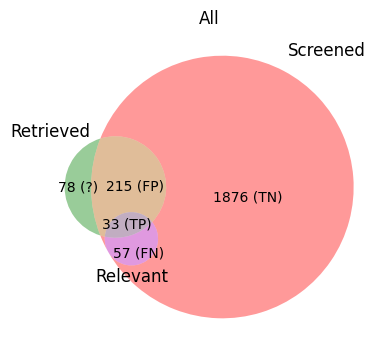

In [33]:
draw_venn_rsi(
    title="All",
    ids_retrieved=metrics_w_manual["All"]["All"]["ids_retrieved"],
    ids_screened=metrics_w_manual["All"]["All"]["ids_screened"],
    ids_screened_relevant=metrics_w_manual["All"]["All"]["ids_screened_relevant"],
    add_pn_labels=True,
);

In [34]:
highlight_metrics(
    metrics_to_df(metrics_w_manual["All"], drop_zero_tp=False).head(
        len(FILTERS_RETRIEVED)
    )
)

,Precision,Recall,$F_1$,TP,FP,FN,TN,?,Retrieved,Screened,Relevant
All,0.1331,0.3667,0.195300,33,215,57,1876,78,326,2181,90
Is RCT,0.1751,0.3444,0.232200,31,146,59,1945,33,210,2181,90
Non-empty Abstract,0.1331,0.3667,0.195300,33,215,57,1876,74,322,2181,90
Non-pediatric population,0.1336,0.3667,0.195800,33,214,57,1877,78,325,2181,90
Phase >= 2,0.2057,0.3222,0.251100,29,112,61,1979,21,162,2181,90
Phase >= 3,0.3387,0.2333,0.276300,21,41,69,2050,1,63,2181,90
Sample Size >= 5,0.1308,0.3444,0.189600,31,206,59,1885,73,310,2181,90
Sample Size >= 10,0.1325,0.3444,0.191400,31,203,59,1888,72,306,2181,90
Sample Size >= 15,0.1354,0.3444,0.194400,31,198,59,1893,67,296,2181,90
Known Intervention,0.1509,0.3556,0.211900,32,180,58,1911,51,263,2181,90


#### RCTs only

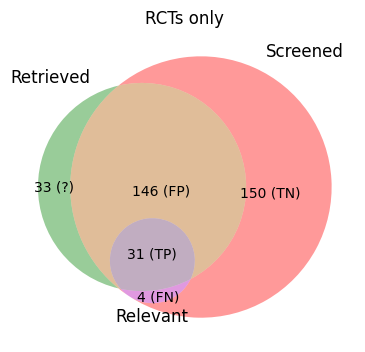

In [35]:
draw_venn_rsi(
    title="RCTs only",
    ids_retrieved=metrics_w_manual["Only RCTs"]["Is RCT"]["ids_retrieved"],
    ids_screened=metrics_w_manual["Only RCTs"]["Is RCT"]["ids_screened"],
    ids_screened_relevant=metrics_w_manual["Only RCTs"]["Is RCT"][
        "ids_screened_relevant"
    ],
    add_pn_labels=True,
);

In [36]:
highlight_metrics(
    metrics_to_df(metrics_w_manual["Only RCTs"], drop_zero_tp=False).head(
        len(FILTERS_RETRIEVED)
    )
)

,Precision,Recall,$F_1$,TP,FP,FN,TN,?,Retrieved,Screened,Relevant
All,0.1751,0.8857,0.292500,31,146,4,150,149,326,331,35
Is RCT,0.1751,0.8857,0.292500,31,146,4,150,33,210,331,35
Non-empty Abstract,0.1751,0.8857,0.292500,31,146,4,150,145,322,331,35
Non-pediatric population,0.1761,0.8857,0.293800,31,145,4,151,149,325,331,35
Phase >= 2,0.2872,0.7714,0.418600,27,67,8,229,68,162,331,35
Phase >= 3,0.3636,0.5714,0.444400,20,35,15,261,8,63,331,35
Sample Size >= 5,0.1696,0.8286,0.281600,29,142,6,154,139,310,331,35
Sample Size >= 10,0.1706,0.8286,0.282900,29,141,6,155,136,306,331,35
Sample Size >= 15,0.1737,0.8286,0.287100,29,138,6,158,129,296,331,35
Known Intervention,0.1987,0.8571,0.322600,30,121,5,175,112,263,331,35


# Final Results (for RCTs)

In [37]:
from evaluation.metrics import build_filter_combinations_table

In [38]:
# Queries for combinations table
Q_RCTS = "is_rct_pt == True & abstract.str.len() > 1"
Q_RCTS_P2 = Q_RCTS + " & phase_int >= 2"
Q_RCTS_P3 = Q_RCTS + " & phase_int >= 3"
Q_RCTS_P3_NC = Q_RCTS_P3 + " & has_pediatric_population == False"
Q_SIG = "(has_significant_finding == True)"
Q_INSIQ = "(has_significant_finding == False)"
Q_KNOWN = "(has_known_intervention == True)"
Q_UNKNOWN = "(has_unknown_intervention == True)"
Q_REC = "(has_recommended_intervention == True)"
Q_UNREC = "(has_not_recommended_intervention == True)"

# Filters for combinations table
FILTERS_COMBINATIONS = {
    "RCTs": Q_RCTS,
    "Phase >= 2": Q_RCTS_P2,
    "Phase >= 3": Q_RCTS_P3,
    "Exclude Children": Q_RCTS_P3_NC,
    
    "Significant" : Q_RCTS_P3_NC + "&" + Q_SIG,
    
    "R" :  Q_RCTS_P3_NC + "&" + Q_REC + "&" + Q_SIG,
    "NR" :  Q_RCTS_P3_NC + "&" + Q_UNREC + "&" + Q_SIG,
}

# Hierarchy for combinations table
FILTERS_HIERARCHY = {
    "RCTs": {
        "Phase >= 2": {
            "Phase >= 3": {
                "Exclude Children": 
                    {
                        "Significant" : ["R", "NR" ],
                    }
                }
            }
        }
}

## Without manual review

In [39]:
combinations_table, metrics_combinations_final = build_filter_combinations_table(
    df_retrieved=df_r,
    df_screened=df_s_with_ggponc.query("screening_origin != 'manual' and screening_origin != 'ggponc'"),
    latex_output_path=PATH_LATEX_TABLE_OUTPUT / "final_metrics.tex",
    overwrite_latex_output=False,
    use_abbreviations=True,
    column_format="llllllS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]S[table-format=2]",
    filters_retrieved = FILTERS_COMBINATIONS,
    filters_retrieved_hierarchy = FILTERS_HIERARCHY,
)
highlight_metrics(combinations_table)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/7 [00:00<?, ?it/s]

In [40]:
print(combinations_table.reset_index()[['Retr.', 'TP', '?', 'FP', 'TN', 'FN', 'Rec.']].round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Retr. &  TP &   ? &   FP &   TN &  FN &  Rec. \\
\midrule
0 &    209 &  22 &  47 &  140 &  150 &   4 &  0.85 \\
1 &     94 &  18 &  15 &   61 &  229 &   8 &  0.69 \\
2 &     55 &  16 &   7 &   32 &  258 &  10 &  0.62 \\
3 &     55 &  16 &   7 &   32 &  258 &  10 &  0.62 \\
4 &     37 &  13 &   5 &   19 &  271 &  13 &  0.50 \\
5 &     31 &  13 &   3 &   15 &  275 &  13 &  0.50 \\
6 &     28 &  10 &   5 &   13 &  277 &  16 &  0.38 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3057356/569929526.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(combinations_table.reset_index()[['Retr.', 'TP', '?', 'FP', 'TN', 'FN', 'Rec.']].round(2).to_latex())


## After manual review

In [41]:
df_manual = pd.read_csv(PATH_MANUAL_REVIEW)

In [42]:
for _, p in df_manual[df_manual.pm_id.isin(df_r.pm_id)].sort_values('is_included').iterrows():
    print(p.is_included, p['Ein- / Ausschlussgrund'])

False Nicht Teil der PICO Fragen - Immuntherapie + Chemo, Toripalimab nicht explizit gesucht 
False Nicht Teil der PICO Fragen -  Ernährung als Intervention
False Nicht Teil der PICO Fragen - keine Dosisvergleiche gesucht
False Nicht Teil der PICO Fragen - keine Genexpressionsstudien gesucht
False narrativer Review, ausgeschlossen
False Gastric Cancer als Population nicht passend
True Durvalumab nicht explizit gesucht weil nicht im PICO Schema, grundsätzlich relevant
True Unklar ob mit oder ohne OP. Pembrolizumab nicht explizit gesucht weil nicht im PICO Schema, grundsätzlich relevant
True Sintilimab nicht explizit gesucht weil nicht im PICO Schema, grundsätzlich relevant
True Trifluridine nicht explizit gesucht weil nicht im PICO Schema, grundsätzlich relevant
True Anlotinib nicht explizit gesucht weil nicht im PICO Schema, grundsätzlich relevant
True Erlotinib nicht explizit gesucht weil nicht im PICO Schema, grundsätzlich relevant
True Grundsätzlich relevant
True Grundsätzlich relev

In [43]:
combinations_table, metrics_combinations_final = build_filter_combinations_table(
    df_retrieved=df_r,
    df_screened=df_s_with_ggponc,
    latex_output_path=None,#PATH_LATEX_TABLE_OUTPUT / "final_metrics.tex",
    overwrite_latex_output=False,
    use_abbreviations=True,
    column_format="llllllS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=3]S[table-format=2]S[table-format=3]S[table-format=3]S[table-format=3]",
    filters_retrieved = FILTERS_COMBINATIONS,
    filters_retrieved_hierarchy = FILTERS_HIERARCHY,
)

highlight_metrics(combinations_table)

Evaluating screened document subset 'All'


Evaluating filter combinations:   0%|          | 0/7 [00:00<?, ?it/s]

Evaluating screened document subset 'Only RCTs'


Evaluating filter combinations:   0%|          | 0/7 [00:00<?, ?it/s]

In [44]:
print(combinations_table.reset_index()[['Retr.', 'TP', '?', 'FP', 'TN', 'FN', 'Prec.', 'Rec.', '$F_1$']].round(2).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  Retr. &  TP &   ? &   FP &   TN &  FN &  Prec. &  Rec. &  \$F\_1\$ \\
\midrule
0 &    209 &  31 &  32 &  146 &  150 &   4 &   0.18 &  0.89 &   0.29 \\
1 &     94 &  27 &   0 &   67 &  229 &   8 &   0.29 &  0.77 &   0.42 \\
2 &     55 &  20 &   0 &   35 &  261 &  15 &   0.36 &  0.57 &   0.44 \\
3 &     55 &  20 &   0 &   35 &  261 &  15 &   0.36 &  0.57 &   0.44 \\
4 &     37 &  15 &   0 &   22 &  274 &  20 &   0.41 &  0.43 &   0.42 \\
5 &     31 &  14 &   0 &   17 &  279 &  21 &   0.45 &  0.40 &   0.42 \\
6 &     28 &  12 &   0 &   16 &  280 &  23 &   0.43 &  0.34 &   0.38 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3057356/1384292062.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(combinations_table.reset_index()[['Retr.', 'TP', '?', 'FP', 'TN', 'FN', 'Prec.', 'Rec.', '$F_1$']].round(2).to_latex())


#### Remaining False Positives

In [45]:
metrics_combinations_final['Only RCTs'].keys()

dict_keys(['RCTs', 'Phase >= 2', 'Phase >= 3', 'Exclude Children', 'Significant', 'R', 'NR'])

In [47]:
ids_false_positives = (
    metrics_to_df(metrics_combinations_final["Only RCTs"], drop_columns=[])
    .sort_values(["Recall", "Precision", "Retrieved"], ascending=[False, False, True])
    .iloc[0]["Ids_fp"]
)

In [48]:
false_positives = df_s_with_ggponc[
    df_s_with_ggponc["pm_id"].apply(lambda pm_id: pm_id in ids_false_positives)
]

In [49]:
false_positives.value_counts("exclusion_reason").to_frame(name="Count")

,Count
exclusion_reason,
TIAB1_exclude,88
TIAB2_exclude,34
FULLTEXT_exclude_Falsche Intervention_Comparison,7
FULLTEXT_exclude_Abstract oder Protokoll,6
FULLTEXT_exclude_Nicht die gesuchte Fragestellung,4
FULLTEXT_exclude_Falsche Population,1
Gastric Cancer als Population nicht passend,1
Nicht Teil der PICO Fragen - Ernährung als Intervention,1
"Nicht Teil der PICO Fragen - Immuntherapie + Chemo, Toripalimab nicht explizit gesucht",1


In [50]:
false_positives[false_positives.exclusion_reason == 'TIAB2_exclude']

,title,abstract,pm_id,nct_id,cn_id,doi,ris_id,publication_date,article_date_api,guideline_id,...,is_relevant,is_not_relevant,is_in_db,is_in_ggponc,screening_origin,rq,rqs_and_reasons,source,publication_date_combined,is_screened
154,Phase III study of tri-modality combination th...,A randomized phase III trial commenced in Japa...,31411696,NaN,NaN,NaN,31411696,2019-08-14,NaT,oesophaguskarzinom,...,False,True,True,False,original,AG7 Multimodale Therapie - Stellenwert und Ind...,[{'rq': 'AG10 Multimodale Therapie - Stellenwe...,NaN,NaT,True
286,Association between time interval from neoadju...,The optimal time interval from neoadjuvant the...,31676895,NaN,NaN,NaN,31676895,2020-05-15,NaT,oesophaguskarzinom,...,False,True,True,False,original,AG10 Multimodale Therapie - Stellenwert der Ko...,"[{'rq': 'AG3', 'exclusion_reason': 'TIAB1_excl...",NaN,NaT,True
318,Preoperative chemotherapy compared with postop...,BACKGROUND: The role of preoperative chemother...,31756547,NaN,NaN,NaN,31756547,2020-01-01,2019-11-20,oesophaguskarzinom,...,False,True,True,False,original,AG9 Multimodale Therapie - Stellenwert der Ope...,[{'rq': 'AG10 Multimodale Therapie - Stellenwe...,NaN,NaT,True
479,A phase-II/III randomized controlled trial of ...,BACKGROUND: Preoperative chemoradiotherapy (CR...,32070309,NaN,NaN,NaN,32070309,2020-02-18,2020-02-18,oesophaguskarzinom,...,False,True,True,False,original,AG9 Multimodale Therapie - Stellenwert der Ope...,[{'rq': 'AG2 Endoskopische Therapie - Vorgehen...,NaN,NaT,True
502,High thromboembolic event rate in patients wit...,BACKGROUND: High rates of venous thromboemboli...,32111181,NaN,NaN,NaN,32111181,2020-02-28,2020-02-28,oesophaguskarzinom,...,False,True,True,False,original,AG9 Multimodale Therapie - Stellenwert der Ope...,[{'rq': 'AG10 Multimodale Therapie - Stellenwe...,NaN,NaT,True
705,Radiochemotherapy with or without cetuximab fo...,PURPOSE: To investigate the efficacy and toxic...,32533228,NaN,NaN,NaN,32533228,2020-09-01,2020-06-12,oesophaguskarzinom,...,False,True,True,False,original,AG7 Multimodale Therapie - Stellenwert und Ind...,[{'rq': 'AG5 Chirurgische Therapie - Stellenwe...,NaN,NaT,True
768,Endoscopic submucosal dissection with addition...,BACKGROUND: Endoscopic submucosal dissection (...,32668474,NaN,NaN,NaN,32668474,2020-12-01,2020-07-15,oesophaguskarzinom,...,False,True,True,False,original,AG10 Multimodale Therapie - Stellenwert der Ko...,[{'rq': 'AG1 Endoskopische Therapie - Indikati...,NaN,NaT,True
868,Recurrence patterns after neoadjuvant chemorad...,BACKGROUND: The aim of this study was to compa...,32877795,NaN,NaN,NaN,32877795,2020-10-01,2020-08-30,oesophaguskarzinom,...,False,True,True,False,original,AG10 Multimodale Therapie - Stellenwert der Ko...,[{'rq': 'AG2 Endoskopische Therapie - Vorgehen...,NaN,NaT,True
898,RACE-trial: neoadjuvant radiochemotherapy vers...,BACKGROUND: Despite obvious advances over the ...,32933498,NaN,NaN,NaN,32933498,2020-09-15,2020-09-15,oesophaguskarzinom,...,False,True,True,False,original,AG9 Multimodale Therapie - Stellenwert der Ope...,[{'rq': 'AG10 Multimodale Therapie - Stellenwe...,NaN,NaT,True
933,Comparison of transhiatal esophagectomy using ...,BACKGROUND: This study aimed to evaluate the r...,32998523,NaN,NaN,NaN,32998523,2021-01-01,2020-09-30,oesophaguskarzinom,...,False,True,True,False,original,AG3,[{'rq': 'AG8 Multimodale Therapie - Rolle des...,NaN,NaT,True


## Missing RCTs

We should be able to find all included RCTs. If not, we need to find out why we did not retrieve them:

In [51]:
metrics_w_manual["Only RCTs"]["All"]["ids_fn"]

{30982686, 31595970, 32421440, 32880601}

In [52]:
from api.utils import query_api_for_concepts, concepts_to_df
from api.models import ConceptsQuery

missing_rcts_df = concepts_to_df(
    query_api_for_concepts(
        ConceptsQuery(
            source="pubmed",
            ids=[
                int(pm_id) for pm_id in metrics_w_manual["Only RCTs"]["All"]["ids_fn"]
            ],
            kind="population",
        )
    )
)

Looks like it is due to vague population concepts:

In [53]:
missing_rcts_df

,cui,term,text_umls,semantic_types
id,,,,
30982686,C0001418,Adenocarcinoma,Adenocarcinoma,"[{'tui': 'T191', 'tree_number': 'B2.2.1.2.1.2'..."
30982686,C0001563,"Administration, Oral",Administration of drug or medicament via oral ...,"[{'tui': 'T061', 'tree_number': 'B1.3.1.3', 'n..."
30982686,C0001675,Adult,Adult,"[{'tui': 'T100', 'tree_number': 'A2.9.4', 'nam..."
30982686,C0001792,Aged,Elderly,"[{'tui': 'T098', 'tree_number': 'A2.9.2', 'nam..."
30982686,C0001795,"Aged, 80 and over","Aged, 80 and over","[{'tui': 'T100', 'tree_number': 'A2.9.4', 'nam..."
...,...,...,...,...
32880601,C2603343,Study,Study,"[{'tui': 'T062', 'tree_number': 'B1.3.2', 'nam..."
32880601,C0599755,Cohort,Cohort,"[{'tui': 'T098', 'tree_number': 'A2.9.2', 'nam..."
32880601,C0439234,year (qualifier value),Year,"[{'tui': 'T079', 'tree_number': 'A2.1.1', 'nam..."


In [54]:
from evaluation.metrics import prepare_missing_rcts_concepts_df

missing_rcts_concepts_df = prepare_missing_rcts_concepts_df(
    missing_rcts_df=missing_rcts_df
)
missing_rcts_concepts_df

UMLS Term
Pubmed ID CUI                                                        
30982686  C0001418                                     Adenocarcinoma
          C1533734                                     Administration
          C0001563  Administration of drug or medicament via oral ...
          C0003393     Antineoplastic Combined Chemotherapy Protocols
          C0038898                           Digestive System Surgery
          C1332166           Gastroesophageal Junction Adenocarcinoma
          C0677984                Locally Advanced Malignant Neoplasm
          C0027627                                         Metastasis
          C0038356                            Neoplasm of the stomach
          C0278498                    Stage IV Gastric Cancer AJCC v7
          C0087111                              Therapeutic Procedure
31595970  C0001418                                     Adenocarcinoma
          C0038898                           Digestive System Surgery
          C0685938            Malignant gastrointestinal tract tumors
          C0017185             Neoplasm of the gastrointestinal tract
          C0543467                                 Surgical Procedure
32421440  C0085198                                      Esophagectomy
          C0282624                         Minimally Invasive Surgery
32880601  C0877373                        Advanced Malignant Neoplasm
          C0003393     Antineoplastic Combined Chemotherapy Protocols
          C1708063                                 First-Line Therapy
          C4744333            Locally Advanced Unresectable Carcinoma
          C0038356                            Neoplasm of the stomach

## Unscreened High Quality Evidence

For this section, we consider all sources. However, we exclude duplicates that are both in Pubmed and in Trialstreamer:

In [55]:
df_query.reset_index(drop=True, inplace=True)
df_query = df_query[
    (
        ~df_query.sort_values(["pm_id", "source"]).duplicated(
            subset="pm_id", keep="first"
        )
    )
    | (df_query["pm_id"].isnull())
]

We then set boolean flags with which we can filter out the already screened evidence:

In [56]:
from evaluation.matching import check_for_matches_in_screened

df_query = check_for_matches_in_screened(
    df_query=df_query, df_screened=df_s_with_ggponc
)

In [57]:
df_query_unscreened = df_query.query("is_screened == False")

In [58]:
pd.crosstab(
    df_query_unscreened["source"],
    df_query_unscreened["has_title_match_in_screened"],
    margins=True,
)

has_title_match_in_screened,False,True,All
source,,,
Civic,2,0,2
ClinicalTrials,34,0,34
Pubmed,77,1,78
All,113,1,114


In [59]:
FILTER_HQ = (
    "is_in_ggponc == False"
    "&"
    "has_title_match_in_screened == False"
    "&"
    "has_pediatric_population == False"
    "&"
    "("
    "(source == 'ClinicalTrials' & phase_int >= 3 & results_available)"
    "|"
    "(source == 'Civic' & evidence_rating >= 4)"
    "|"
    "(source == 'Pubmed' & abstract.str.len() > 1 & is_rct == True & phase_int >= 2)"
    ")"
)

In [60]:
df_query_unscreened_hq = df_query_unscreened.query(FILTER_HQ)

manual_review = df_query_unscreened_hq.sort_values(
    ["source", "publication_date"], ascending=False
)
manual_review

,title,abstract,publication_date,source,pm_id,pmc_id,nct_id,referenced_nct_ids,referenced_pm_ids,phase,...,interventions_recommended,interventions_not_recommended,cpg_matches_population,cpg_matches_intervention,guideline_id,article_date_api,publication_date_combined,is_in_ggponc,is_screened,has_title_match_in_screened
340,"Radiation Therapy, Paclitaxel, and Carboplatin...",This randomized phase III trial studies how we...,2021-05-04,ClinicalTrials,<NA>,None,NCT01196390,[],[35038433],PHASE3,...,"[chemotherapy agent, trastuzumab, antineoplast...","[carboplatin, trastuzumab biosimilar hlx02, an...",[oesophaguskarzinom],"[pomgat, palliativmedizin, endometriumkarzinom...",oesophaguskarzinom,NaT,2021-05-04,False,False,False
356,Study of Pembrolizumab (MK-3475) Versus Invest...,"In the China extension study, Chinese particip...",2020-02-26,ClinicalTrials,<NA>,None,NCT03933449,[],[34973513],PHASE3,...,"[chemotherapy agent, pembrolizumab, antineopla...","[irinotecan, antineoplastic agents, phytogenic...",[oesophaguskarzinom],"[pomgat, palliativmedizin, endometriumkarzinom...",oesophaguskarzinom,NaT,2020-02-26,False,False,False


In [61]:
df_query_unscreened_hq.to_csv(PATH_UNSCREENED_HQ, index=False)

### Latex Output

In [62]:
from evaluation.metrics import remove_last_cline_from_tex_table

#### Missing RCTs

In [63]:
if OVERWRITE_LATEX_OUTPUT:
    missing_rcts_concepts_df[["UMLS Term"]].style.format(escape="latex").to_latex(
        PATH_LATEX_TABLE_OUTPUT / f"missing_rcts.tex",
        hrules=True,
        clines="skip-last;data",
    )
    remove_last_cline_from_tex_table(PATH_LATEX_TABLE_OUTPUT / f"missing_rcts.tex")

#### Retrieval Metrics

In [64]:
if OVERWRITE_LATEX_OUTPUT:
    for subset_screened_desc in metrics_w_manual.keys():
        if subset_screened_desc == "All":
            column_format = "lS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=3]S[table-format=2]S[table-format=4]S[table-format=2]S[table-format=3]"
        else:
            column_format = "lS[table-format=1.2]S[table-format=1.2]S[table-format=1.2]S[table-format=2]S[table-format=3]S[table-format=2]S[table-format=3]S[table-format=3]S[table-format=3]"
        highlight_metrics(
            metrics_to_df(
                metrics_w_manual[subset_screened_desc],
                drop_zero_tp=False,
                use_abbreviations=True,
            )
            .head(len(FILTERS_RETRIEVED))
            .drop(columns=["Scr.", "Rel."])
        ).applymap_index(lambda v: "font-weight: bold;", axis="columns").to_latex(
            PATH_LATEX_TABLE_OUTPUT / f"prec_rec_{subset_screened_desc}.tex",
            hrules=True,
            convert_css=True,
            siunitx=True,
            clines="all;data",
            column_format=column_format,
        )
        remove_last_cline_from_tex_table(
            PATH_LATEX_TABLE_OUTPUT / f"prec_rec_{subset_screened_desc}.tex"
        )

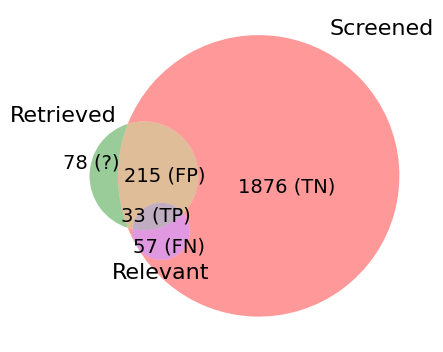

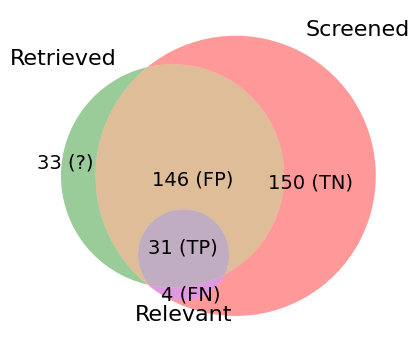

In [65]:
if OVERWRITE_LATEX_OUTPUT:
    for subset_screened_desc, subset_retrieved_desc in zip(
        ["All", "Only RCTs"], ["All", "Is RCT"]
    ):
        fig, ax = draw_venn_rsi(
            title=None,
            ids_retrieved=metrics_w_manual[subset_screened_desc][subset_retrieved_desc][
                "ids_retrieved"
            ],
            ids_screened=metrics_w_manual[subset_screened_desc][subset_retrieved_desc][
                "ids_screened"
            ],
            ids_screened_relevant=metrics_w_manual[subset_screened_desc][
                subset_retrieved_desc
            ]["ids_screened_relevant"],
            add_pn_labels=True,
            circle_label_size=16,
            label_size=14,
            label_offsets={"?": (-0.05, 0.05)},
        )
        fig.savefig(
            PATH_LATEX_PLOT_OUTPUT
            / f"venn3_screened_found_included_{subset_screened_desc}.pdf",
        )

#### Screening Data

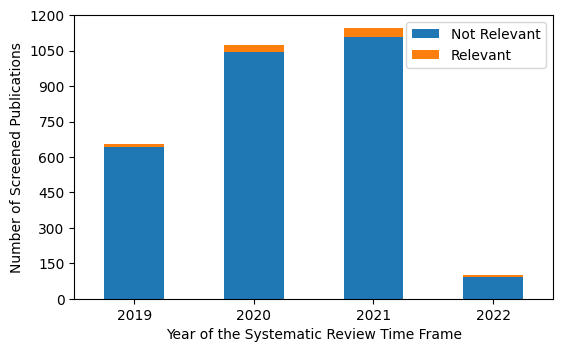

In [66]:
from evaluation.plotting import draw_docs_by_publication_date

if OVERWRITE_LATEX_OUTPUT:
    draw_docs_by_publication_date(
        df_screened=df_s,
        col_date="publication_date",
        col_relevant="is_relevant",
        output_dir=PATH_LATEX_PLOT_OUTPUT,
        file_name=f"screened_by_publication_year.pdf",
    )

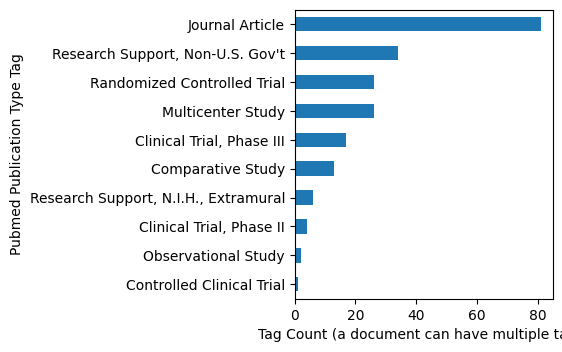

In [67]:
from evaluation.plotting import draw_docs_publication_types

if OVERWRITE_LATEX_OUTPUT:
    draw_docs_publication_types(
        df_screened=df_s,
        n_most_common=10,
        col_ptypes="publication_types",
        col_relevant="is_relevant",
        output_dir=PATH_LATEX_PLOT_OUTPUT,
        file_name=f"publication_types_included.pdf",
    )

#### Retrieved Data

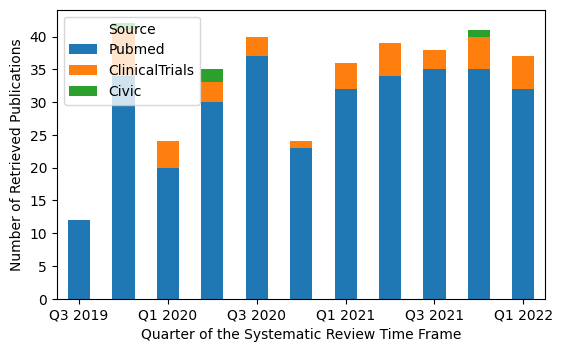

In [68]:
from evaluation.plotting import set_size
from matplotlib.dates import AutoDateLocator

if OVERWRITE_LATEX_OUTPUT:
    monthly_retrievals = (
        df_query.query("source != 'Trialstreamer'")
        .groupby([pd.Grouper(key="publication_date_combined", freq="3M"), "source"])
        .size()
        .unstack()
        .rename(index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}")
        .rename_axis("Source", axis=1)
    )[["Pubmed", "ClinicalTrials", "Civic"]]

    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")
    monthly_retrievals.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        xlabel="Quarter of the Systematic Review Time Frame",
        ylabel="Number of Retrieved Publications",
        rot=0,
    )
    locator = AutoDateLocator()
    locator.intervald["QUARTER"] = 1
    ax.xaxis.set_major_locator(locator)
    fig.savefig(PATH_LATEX_PLOT_OUTPUT / f"monthly_retrievals_by_source.pdf")

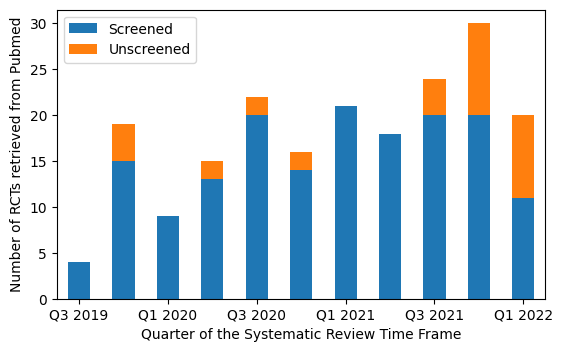

In [69]:
if OVERWRITE_LATEX_OUTPUT:
    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")

    monhtly_retrieved_vs_screened_pm = (
        df_query.query("source == 'Pubmed' & is_rct_pt == True & is_in_ggponc == False")
        .merge(df_s[["pm_id", "is_included"]], on="pm_id", how="left", indicator=True)
        .groupby([pd.Grouper(key="publication_date_combined", freq="3M"), "_merge"])
        .size()
        .unstack()[["both", "left_only"]]
        .rename(
            index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}",
            columns={"left_only": "Unscreened", "both": "Screened"},
        )
        .rename_axis(None, axis=1)
    )

    monhtly_retrieved_vs_screened_pm.plot(
        kind="bar",
        stacked=True,
        ylabel="Number of RCTs retrieved from Pubmed",
        xlabel="Quarter of the Systematic Review Time Frame",
        ax=ax,
        rot=0,
    )

    locator = AutoDateLocator()
    locator.intervald["QUARTER"] = 1
    ax.xaxis.set_major_locator(locator)

    fig.savefig(PATH_LATEX_PLOT_OUTPUT / f"monthly_retrieved_vs_screened_rcts.pdf")

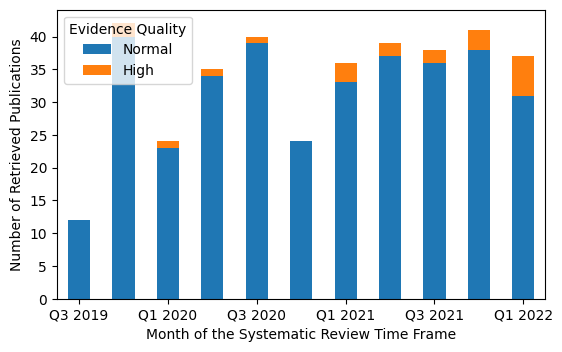

In [70]:
if OVERWRITE_LATEX_OUTPUT:
    df_query.loc[df_query.query(FILTER_HQ).index, "is_hq"] = True
    df_query["is_hq"] = df_query["is_hq"].fillna(False)

    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")
    df_query.query("source != 'Trialstreamer'").groupby(
        [pd.Grouper(key="publication_date_combined", freq="3M"), "is_hq"]
    ).size().unstack().rename(
        index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}",
        columns={True: "High", False: "Normal"},
    ).rename_axis(
        "Evidence Quality", axis=1
    ).plot(
        kind="bar",
        stacked=True,
        ax=ax,
        xlabel="Month of the Systematic Review Time Frame",
        ylabel="Number of Retrieved Publications",
        rot=0,
    )
    locator = AutoDateLocator()
    locator.intervald["QUARTER"] = 1
    ax.xaxis.set_major_locator(locator)

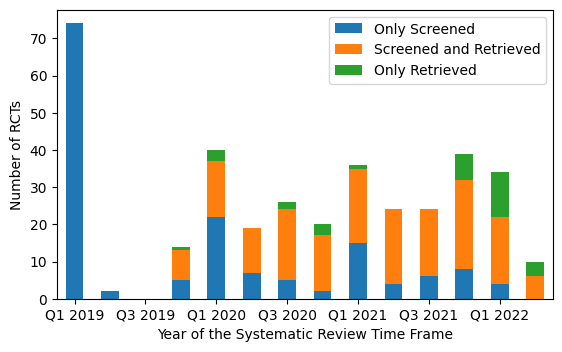

In [71]:
if OVERWRITE_LATEX_OUTPUT:
    df_merged = (
        df_query.query("source == 'Pubmed' & is_rct_pt == True")
        .dropna(subset="pm_id")
        .merge(
            df_s.query("is_rct_api == True")[
                ["pm_id", "publication_date", "is_included"]
            ].dropna(subset="pm_id"),
            on="pm_id",
            how="outer",
            indicator=True,
        )
    )
    df_merged["common_publication_date"] = df_merged[
        "publication_date_combined"
    ].fillna(df_merged["publication_date_y"])

    montly_retrieved_vs_screened = (
        df_merged.groupby(
            [pd.Grouper(key="common_publication_date", freq="3M"), "_merge"]
        )
        .size()
        .unstack()
        .rename(
            index=lambda d: f"Q{pd.Timestamp(d).quarter} {d.year}",
            columns={
                "left_only": "Only Retrieved",
                "both": "Screened and Retrieved",
                "right_only": "Only Screened",
            },
        )
        .rename_axis(None, axis=1)
    )[["Only Screened", "Screened and Retrieved", "Only Retrieved"]]

    fig, ax = plt.subplots(figsize=set_size("thesis"), layout="constrained")
    montly_retrieved_vs_screened.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        xlabel="Year of the Systematic Review Time Frame",
        ylabel="Number of RCTs",
        rot=0,
    )
    locator = AutoDateLocator()
    locator.intervald["QUARTER"] = 1
    ax.xaxis.set_major_locator(locator)

    fig.savefig(PATH_LATEX_PLOT_OUTPUT / f"yearly_retrieved_vs_screened_rcts.pdf")